In [1]:
import random
import os
import sys
import warnings
import logging
import pickle
from typing import Any
from copy import copy, deepcopy
from IPython.display import clear_output, Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import gplearn
import pydotplus
from sklearn.metrics import mean_squared_error
from gplearn.genetic import SymbolicRegressor
from gplearn.fitness import make_fitness
from gplearn.functions import make_function

warnings.simplefilter('ignore', RuntimeWarning)

# import torch
# from public_fu.fu_roll_max import calRollMax
# from public_fu.fu_roll_mean import calRollMean

# from quant.loader.manager import from_in_sample

logger = logging.getLogger(__name__)
logging.basicConfig(filename='trans_anomaly.log', encoding='utf-8', level=logging.DEBUG)
# dm = from_in_sample('my_project')
clear_output()

In [2]:
# ret = np.random.randn(1, 500, 5000)
# ind = np.random.randint(0, 30, (1, 500, 5000))
# mask = np.random.random((1, 500, 5000)) > 0.9
# ret = np.where(mask, np.nan, ret)
from typing import *
from typing import Any

def winsorize(weight: np.ndarray, left: float = 0., right: float = 1.):
    '''Winsorize weight matrix so each day, weight percentiles lower
    than left bound / higher than right bound will be clipped to
    boundary values. WARNING: There is no validation on parameters for
    performance.
    
    Parameters
    ----------
    weight : array-like, shape = (n_days, n_firms)
        Raw portfolio weight.
        
    left : float, default = 0.
        Left boundary (minimum) percentile for each day in range (0., 1.). 
        
    right : float, default = 1.
        Right boundary (maximum) percentile for each day in range (0., 1.). 
        
    Returns
    -------
    weight_winsorized : array-like of shape (n_days, n_firms)
        The winsorized weight array.
    '''
    minimum, maximum = np.nanquantile(weight, (left, right), axis=1)
    weight = np.clip(weight, minimum[..., None], maximum[..., None])
    return weight

def neutralize(weight: np.ndarray, industry: Union[None, np.ndarray] = None):
    '''Neutralize weight matrix so each day, positive and negative
    weights sum up to 0.
    
    Parameters
    ----------
    weight : array-like, shape = (n_days, n_firms)
        Raw portfolio weight.
        
    industry : Union[None, array-like], default = None
        If provided, must be int-like matrix of shape (n_days, n_firms).
        Industry classification for neutralization within each group, if
        not provided, neutralize all intruments within the market.
        
    Returns
    -------
    weight_neutralized : array-like of shape (n_days, n_firms)
        The neutralized weight array, so at each day long and short
        sides sum up to 0.
    '''
    # Market-wise neutralization if no industry info.
    if industry is None:
        return weight - np.nanmean(weight, axis=1, keepdims=True)
    if industry.shape != weight.shape:
        raise ValueError(f'Weight and industry have different shape:'
                         f'{weight.shape}, {industry.shape}')
    ind_ls = np.unique(industry)
    # Use loop as matrix representation costs too much memory.
    for i in ind_ls:
        if not np.isfinite(i): continue
        mask = (industry == i)
        mean = np.nanmean(np.where(mask, weight, 0.), axis=1, keepdims=True)
        weight -= np.where(mask, mean, 0.)
    return weight

def rebalance(weight: np.ndarray, min_obs: int = 1):
    '''Rebalance long and short side so they sum up to +- 1. Do not
    require the weight to be neutralized in advance. If either side has
    valid stocks lower than min_obs, treat the whole side as 0.
    
    Parameters
    ----------
    weight : array-like of shape (n_days, n_firms)
        Raw portfolio weight.
    
    min_obs: int, default=1
        At each day if long / short side have valid weight count lower
        than this value, all weights on that side are set to 0.
        
    Returns
    -------
    weight_balanced : array-like of shape (n_days, n_firms)
        The balanced weight array, so at each day weights on long side
        sum up to 1, and short side to -1.
    '''
    pos_mask = weight > 0.
    pos_count = pos_mask.sum(axis=1, keepdims=True)
    pos_sum = np.where(pos_mask, weight, 0.).sum(axis=1, keepdims=True)
    pos_sum = np.where(pos_count < min_obs, np.inf, pos_sum)
    neg_mask = weight < 0.
    neg_count = neg_mask.sum(axis=1, keepdims=True)
    neg_sum = -np.where(neg_mask, weight, 0.).sum(axis=1, keepdims=True)
    neg_sum = np.where(neg_count < min_obs, np.inf, neg_sum)
    weight = np.where(pos_mask, weight / pos_sum, weight)
    weight = np.where(neg_mask, weight / neg_sum, weight)
    return weight

def clip_limit(weight: np.ndarray, permit_long: np.ndarray, 
               permit_short: np.ndarray):
    '''Clip weight based on price limit info, so firm-day weight cannot
    be higher than previous value unless permit_long is True, and vice
    versa. 
    
    Parameters
    ----------
    weight : array-like of shape (n_days, n_firms)
        Raw portfolio weight.
    
    permit_long: array-like of shape (n_days, n_firms)
        A firm-day's weight will be clipped to previous value if higher
        and not permitted to long.
        
    permit_short: array-like of shape (n_days, n_firms)
        A firm-day's weight will be clipped to previous value if lower
        and not permitted to short.
        
    Returns
    -------
    weight_clipped : array-like of shape (n_samples, n_days, n_firms)
        The clipped weight array, so unless a firm-day is permitted to
        be furtherly long / short-ed, its weight cannot be hihger /
        lower than previous value.
    '''
    # Fillna as NaN cannot be compared.
    mask = np.isfinite(weight)
    weight = np.where(mask, weight, 0.)
    greater = weight > np.roll(weight, 1, axis=0)
    greater[0] = weight[0] > 0.
    valid = (permit_long | ~greater) & (permit_short | greater)
    # Similar to pandas's ffill.
    idx = np.tile(np.arange(valid.shape[0]), (valid.shape[1], 1)).T
    idx = np.where(valid, idx, 0)
    np.maximum.accumulate(idx, axis=0, out=idx)
    weight[~valid] = weight[idx[~valid], np.nonzero(~valid)[1]]
    weight = np.where(mask, weight, np.nan)
    return weight   

def sharpe_fitness(y: np.ndarray, y_pred: np.ndarray, 
                   sample_weight: np.ndarray):
    '''Calculate sharpe ratio (without rf rate) for time-series, take
    mean along n_samples dim. The user should manually create delay0 ret
    for delay1 weight, or delay-1 for delay0.
    
    Parameters
    ----------
    y : array-like, shape = (n_days, n_firms)
        Daily delay0 close-to-close returns, i.e. day-t return to be BNH
        return if bought at the close price of day-t-1 and hold to day-t
        close.
    y_pred : array-like of shape (n_days, n_firms)
        Daily delay1 portfolio weight, i.e. day-t weight must can be
        calculated only using information prior to day-t-1 close.
    sample_weight: None or array-like of shape (n_days, n_firms)
        Daily delay0 sample weight. For sharpe metrics, only consider
        weight at daily level, i.e. weight will be reduced to 1d by
        np.nanmean()
        
    Returns
    -------
    sharpe_ratio : float
        Sharpe ratio averaged along n_samples dim.
    '''
    # A point is valid if has both finite weight and returns, otherwise
    # treat weight as 0.
    mask = np.isfinite(y) & np.isfinite(y_pred)
    # Penalize invalid weight.
    if mask.mean() < 0.2 or (np.abs(y_pred[mask]) < 1e-16).mean() > 0.9:
        return -100.
    # Turnover
    tvr = np.where(mask, y_pred, 0.)
    tvr[1:] = tvr[1:] - tvr[:-1]
    tvr = np.abs(tvr).sum(axis=1)
    # Weighted return, penalized by turnover at rate of two-sided 5e-4.
    ret_daily = np.where(mask, y_pred * y, 0.).sum(axis=1) - 5e-4 * tvr
    # Non-compounding daily weighted returns and volatility.
    sample_weight = np.nanmean(sample_weight, axis=1)
    ret_mean = np.sum(ret_daily * sample_weight) / sample_weight.sum()
    ret_daily -= ret_mean
    ret_daily *= ret_daily
    vol = np.sum(ret_daily * sample_weight) / sample_weight.sum()
    vol = np.inf if vol < 1e-8 else np.sqrt(vol)
    return ret_mean / vol * np.sqrt(250)

def all_stats(y, y_pred, start_size=1.):
    '''Used only for 2D DataFrame summary.'''
    def get_stats(df):
        res_dict = {
            'days': df.shape[0],
            'ret': df['return'].mean(),
            'sharpe': df['return'].mean() / df['return'].std() * np.sqrt(250),
            'ret_long': df['return_long'].mean(),
            'sharpe_long': df['return_long'].mean() / df['return_long'].std() \
                * np.sqrt(250),
            'long_size': df['long_size'].mean(),
            'short_size': df['short_size'].mean(),
            'min_coverage': df['coverage'].min(),
            'coverage': df['coverage'].mean(),
            'maxwt': df['max_weight'].max(),
            'avg_maxwt': df['max_weight'].mean(),
            'max_tvr': df['turnover'].max(),
            'avg_tvr': df['turnover'].mean(),
            'max_dd': (df['cumret'] - df['cumret'].cummax()).min(),
        }
        return pd.Series(res_dict)
        
    if y.shape != y_pred.shape:
        raise ValueError(f'y and y_pred have different shape: '
                         f'{y.shape}, {y_pred.shape}')
    if len(y.shape) != 2:
        raise ValueError(f'Expect 2d input (date, firm), '
                         f'got {y.shape}')
    mask = np.isfinite(y) & np.isfinite(y_pred)
    wt = y_pred.where(mask, 0.)
    tvr = wt.diff(1)
    tvr.iloc[0] = wt.iloc[0]
    ret = y_pred * y
    res = (mask.sum(axis=1) / np.isfinite(y).sum(axis=1)).to_frame('coverage')
    res['long_size'] = wt.where(wt > 0., 0.).sum(axis=1)
    res['short_size'] = wt.where(wt < 0., 0.).sum(axis=1)
    res['turnover'] = tvr.abs().sum(axis=1)
    res['return'] = ret.sum(axis=1)
    res['return'] -= 5e-4 * res['turnover']
    res['return_long'] = ret.where(wt > 0., 0.).sum(axis=1)
    res['return_long'] -= 5e-4 * tvr.where(tvr > 0., 0.).sum(axis=1)
    res['cumret'] = res['return'].cumsum() + start_size
    res['max_weight'] = wt.abs().max(axis=1)
    grouper = pd.Grouper(freq='Y')
    stats = res.groupby(grouper).apply(get_stats)
    stats.index = stats.index.year
    full = get_stats(res).to_frame('ALL').T
    stats = pd.concat([stats, full], axis=0)
    return stats, res['cumret']

def transform_weight(weight: np.ndarray, trans_args: dict):
    '''User-made pipeline function to transform raw weights to valid ones.'''
    # Makes scalar invalid
    unique = np.unique(weight)
    if len(np.unique(weight)) - int(np.nan in unique) < 2:
        return np.empty_like(weight) * np.nan
    fields = list(trans_args.keys())
    if 'universe' in fields:
        weight = np.where(trans_args['universe'], weight, np.nan)
    weight = winsorize(weight, 0.02, 0.98)
    weight = neutralize(weight, industry=trans_args.get('industry', None))
    weight = rebalance(weight, min_obs=1)
    if 'permit_long' in fields and 'permit_short' in fields:
        weight = clip_limit(weight, trans_args['permit_long'], 
                            trans_args['permit_short'])
    return weight  

def ic_fitness(y: np.ndarray, y_pred: np.ndarray, sample_weight: np.ndarray):
    '''Calculate cross-sectional IC value, which is the mean of daily
    correlation between stock weight and (next-day) returns. The user should
    manually create delay0 ret for delay1 weight, or delay-1 for delay0.

    NOTE: It is tempting to take absolute value of calculated IC to keep strong
    negative correlated result, but it is usually inpractical to hold such a
    inversed portfolio. For this, real IC is returned instead of absolute and
    negative results are expected to be discarded.
    
    Parameters
    ----------
    y : array-like, shape = (n_days, n_firms)
        Daily delay0 close-to-close returns, i.e. day-t return to be BNH return
        if bought at the close price of day-t-1 and hold to day-t close.
        
    y_pred : array-like of shape (n_days, n_firms)
        Daily delay1 portfolio weight, i.e. day-t weight must can be calculated
        only using information prior to day-t-1 close.
        
    sample_weight: None or array-like of shape (n_days, n_firms)
        Daily delay0 sample weight. For IC metrics, only consider weight at
        daily level, i.e. weight will be reduced to 1d by np.nanmean()
        
    Returns
    -------
    ic_coef : float
        Sample period value of mean daily IC, which is the correlation
        coef between daily stock weights and returns.
    '''
    mask = np.isfinite(y) & np.isfinite(y_pred)
    # Penalize invalid weight.
    if mask.mean() < 0.4 or (np.abs(y_pred[mask]) < 1e-16).mean() > 0.8:
        return -1.
    y, y_pred = np.where(mask, y, 0.), np.where(mask, y_pred, 0.)
    y = np.where(mask, y - y.mean(axis=1, keepdims=True), 0.)
    y_pred = np.where(mask, y_pred - y_pred.mean(axis=1, keepdims=True), 0.)
    corr = (y * y_pred).sum(axis=1)
    corr /= np.sqrt((y*y).sum(axis=1) * (y_pred*y_pred).sum(axis=1))
    sample_weight = np.nanmean(sample_weight, axis=1)
    corr = np.nansum(corr * sample_weight) / np.nansum(sample_weight)
    return corr


class DynamicParamCallback:
    '''Dynamically change fit params to control performance.
    This callback abuses __dict__ feature of python class, use it with
    caution.
    '''
    def __init__(self, min_fitness=None, min_variety=None, 
                 max_avg_length=None):
        assert isinstance(min_fitness, float)
        assert 0. < min_variety < 1.
        assert max_avg_length > 1
        self.min_fitness = min_fitness
        self.min_variety = min_variety
        self.max_avg_length = max_avg_length
        self.args = None

    def __call__(self, obj):
        if self.args is None:
            self.args = obj.get_params(raw=True)
        # Use aggressive params if either:
        #   1. Best fitness is lower than threshold
        #   2. Population variety is lower than threshold
        fitness = self.min_fitness is not None \
            and obj.run_details_['best_fitness'][-1] < self.min_fitness
        variety = self.min_variety is not None \
            and obj.run_details_['variety'][-1] < self.min_variety
        length = self.max_avg_length is not None \
            and obj.run_details_['average_length'][-1] > self.max_avg_length
        # No selection pressure, exploration proritized
        if fitness or variety:
            obj.__dict__.update({
                'tournament_size': 2,
                'p_crossover': 0.44,
                'p_subtree_mutation': 0.4,
                'p_hoist_mutation': 0.05,
                'p_point_mutation': 0.1,
                'p_point_replace': 0.5,
            })
        else:
            obj.__dict__.update(self.args)
        # Shrink length by stronger hoist prob.
        hoist = obj.__dict__['p_hoist_mutation']
        if length and hoist < .4:
            ratio = (.8 - hoist) / (1. - hoist)
            hoist += .2
            obj.p_hoist_mutation = hoist
            obj.p_crossover *= ratio
            obj.p_subtree_mutation *= ratio
            obj.p_point_mutation *= ratio
            

class SaveCallback:
    def __init__(self, file='./last_gen.pkl'):
        self.file = file
        
    def __call__(self, obj):
        with open(self.file, 'wb') as f:
            pickle.dump(obj, f)
        
        

# metric = make_fitness(function=sharpe_fitness, greater_is_better=True)
metric = make_fitness(function=ic_fitness, greater_is_better=True)
transform = make_function(function=transform_weight, name='trans', arity=2)

In [3]:
# Read from parquet sample
df = pd.read_parquet('./test_data/data.parquet')
numeric = ['open', 'high', 'low', 'close']
df[numeric] = df[numeric].astype(np.float64)
df.reset_index(inplace=True)
open_, high, low, close, permit_long, permit_short, pool = \
    [df.pivot(index='date', columns='ticker',values=i) 
     for i in ['open', 'high', 'low', 'close', 
               'permit_long', 'permit_short', 'pool']]
permit_long = permit_long.fillna(True).astype(bool)
permit_short = permit_short.fillna(True).astype(bool)
pool = pool.fillna(False).astype(bool)

# # Read from DMGR
# adj = dm['CUM_ADJ_FACTOR'].data_array.to_pandas()
# open_ = dm['OPENPRICE'].data_array.to_pandas() * adj
# high = dm['HIGHPRICE'].data_array.to_pandas() * adj
# low = dm['LOWPRICE'].data_array.to_pandas() * adj
# close = dm['CLOSEPRICE'].data_array.to_pandas() * adj
# permit_long = ~dm['close_up_limit'].data_array.to_pandas()\
#     .shift(1, fill_value=False)
# permit_short = ~dm['close_down_limit'].data_array.to_pandas()\
#     .shift(1, fill_value=False)
# valid = dm['TURNOVERVOLUME'].data_array.to_pandas().shift(1, fill_value=False) > 0.
# permit_long &= valid
# permit_short &= valid
# pool = dm['valid_broad'].data_array.to_pandas()

prev = close.shift(1)
high = (high / open_ - 1.).clip(-.2, .2)
low = (low / open_ - 1.).clip(-.2, .2)
# Close to Open (overnight)
open_ = (open_ / prev - 1.).clip(-.2, .2)
# Close to Close
close = (close / prev - 1.).clip(-.2, .2)

open_ = open_.shift(2).loc['2009-01-01':]
high = high.shift(2).loc['2009-01-01':]
low = low.shift(2).loc['2009-01-01':]
ret = close.loc['2009-01-01':]
close = close.shift(2).loc['2009-01-01':]
permit_long = permit_long.loc['2009-01-01':]
permit_short = permit_short.loc['2009-01-01':]
pool = pool.loc['2009-01-01':]

ret -= ret.mean(axis=1).to_numpy()[..., None]

x_full = [open_, high, low, close]
add_full = {
    'universe': pool,
    'permit_long': permit_long,
    'permit_short': permit_short,
}

is_start, is_end, os_end = '2020-01-01', '2021-12-31', '2022-03-31'
x_is = [i[is_start: is_end] for i in [open_, high, low, close]]
x_os = [i[is_end: os_end] for i in [open_, high, low, close]]
y_is = ret[is_start: is_end]
y_os = ret[is_end: os_end]
add_is = {
    'universe': pool[is_start: is_end],
    'permit_long': permit_long[is_start: is_end],
    'permit_short': permit_short[is_start: is_end],
}
add_os = {
    'universe': pool[is_end: os_end],
    'permit_long': permit_long[is_end: os_end],
    'permit_short': permit_short[is_end: os_end],
}
clear_output()

In [4]:
# # Save sample data
# open_ = open_.loc['2020-01-01':'2021-12-31'].astype(np.float32)\
#     .stack(-1).reset_index(name='open')
# high = high.loc['2020-01-01':'2021-12-31'].astype(np.float32)\
#     .stack(-1).reset_index(name='high')
# low = low.loc['2020-01-01':'2021-12-31'].astype(np.float32)\
#     .stack(-1).reset_index(name='low')
# close = close.loc['2020-01-01':'2021-12-31'].astype(np.float32)\
#     .stack(-1).reset_index(name='close')
# permit_long = permit_long.loc['2020-01-01':'2021-12-31']\
#     .stack(-1).reset_index(name='permit_long')
# permit_short = permit_short.loc['2020-01-01':'2021-12-31']\
#     .stack(-1).reset_index(name='permit_short')
# pool = pool.loc['2020-01-01':'2021-12-31'].stack(-1).reset_index(name='pool')
# test = None
# for i in [open_, high, low, close, permit_long, permit_short, pool]:
#     test = i if test is None else pd.merge(test, i, 'inner', ['date', 'ticker'])
# test['ticker'] = test['ticker'].astype('category')
# mask = test['ticker'].str.endswith(('SH', 'SZ'))
# test = test.loc[mask, :]
# test.set_index(['date', 'ticker'], inplace=True)
# test.dropna(inplace=True)
# test.to_parquet('./test_data/data.parquet')
# test.info()

In [5]:
# from gplearn.tsfunctions import fu_factory
# from vanilla_fu.fu_roll_alphabeta import calRollAlphaBeta as RAB
# from vanilla_fu.fu_roll_argmax import calRollArgMax as RAMax
# from vanilla_fu.fu_roll_argmin import calRollArgMin as RAMin
# from vanilla_fu.fu_roll_corr import calRollCorr as RC
# from vanilla_fu.fu_roll_decay_linear import calRollDecayLinear as RDL
# from vanilla_fu.fu_roll_kurt import calRollKurt as RK
# from vanilla_fu.fu_roll_max import calRollMax as RMax
# from vanilla_fu.fu_roll_mean import calRollMean as RMean
# from vanilla_fu.fu_roll_median import calRollMedian as RMedian
# from vanilla_fu.fu_roll_min import calRollMin as RMin
# from vanilla_fu.fu_roll_skew import calRollSkew as RSkew
# from vanilla_fu.fu_roll_std import calRollStd as RStd
# from vanilla_fu.fu_roll_zscore import calRollZscore as RZ

# default_range = [2, 5, 10, 20, 60]
# long_range = [5, 10, 20, 60]

# rbeta = fu_factory(RAB, 'res_beta', name='rbeta', arity=2, 
#                    valid_range=long_range, total_ignore_nan=False, 
#                    res_stats=False)
# ralpha = fu_factory(RAB, 'res_alpha', name='ralpha', arity=2, 
#                     valid_range=long_range, total_ignore_nan=False,  
#                     res_stats=False)
# riv = fu_factory(RAB, 'res_err_std', name='riv', arity=2, 
#                  valid_range=long_range, total_ignore_nan=False, 
#                  res_stats=True)
# rargmax = fu_factory(RAMax, 'res', name='rargmax', arity=1,
#                      valid_range=default_range, total_ignore_nan=False)
# rargmin = fu_factory(RAMin, 'res', name='rargmin', arity=1,
#                      valid_range=default_range, total_ignore_nan=False)
# rcorr = fu_factory(RC, 'res', name='rcorr', arity=2, valid_range=long_range,
#                    total_ignore_nan=False, flag=True)
# rdecay = fu_factory(RDL, 'res', name='rdecay', arity=1, 
#                     valid_range=default_range, total_ignore_nan=False)
# rkurt = fu_factory(RK, 'res', name='rkurt', arity=1, valid_range=long_range,
#                    total_ignore_nan=False, flag=True)
# rmax = fu_factory(RMax, 'res', name='rmax', arity=1, 
#                    valid_range=default_range, total_ignore_nan=False)
# rmean = fu_factory(RMean, 'res', name='rmean', arity=1, 
#                    valid_range=default_range, total_ignore_nan=False)
# rmedian = fu_factory(RMedian, 'res', name='rmedian', arity=1, 
#                      valid_range=long_range, total_ignore_nan=False)
# rmin = fu_factory(RMin, 'res', name='rmin', arity=1, 
#                    valid_range=default_range, total_ignore_nan=False)
# rskew = fu_factory(RSkew, 'res', name='rskew', arity=1, valid_range=long_range,
#                    total_ignore_nan=False, flag=True)
# rstd = fu_factory(RStd, 'res', name='rstd', arity=1, valid_range=long_range,
#                    total_ignore_nan=False, flag=True)
# rzscore = fu_factory(RZ, 'res', name='rzscore', arity=1, 
#                      valid_range=list(zip(long_range, long_range)), 
#                      total_ignore_nan=False, flag=True)

div(div(abs(mul(0.588, sqrt(X3))), add(abs(sub(X3, X0)), sqrt(abs(X2)))), div(abs(div(X3, div(X0, -0.337))), sub(mul(add(0.295, X3), div(X2, X0)), abs(div(-0.336, X2)))))


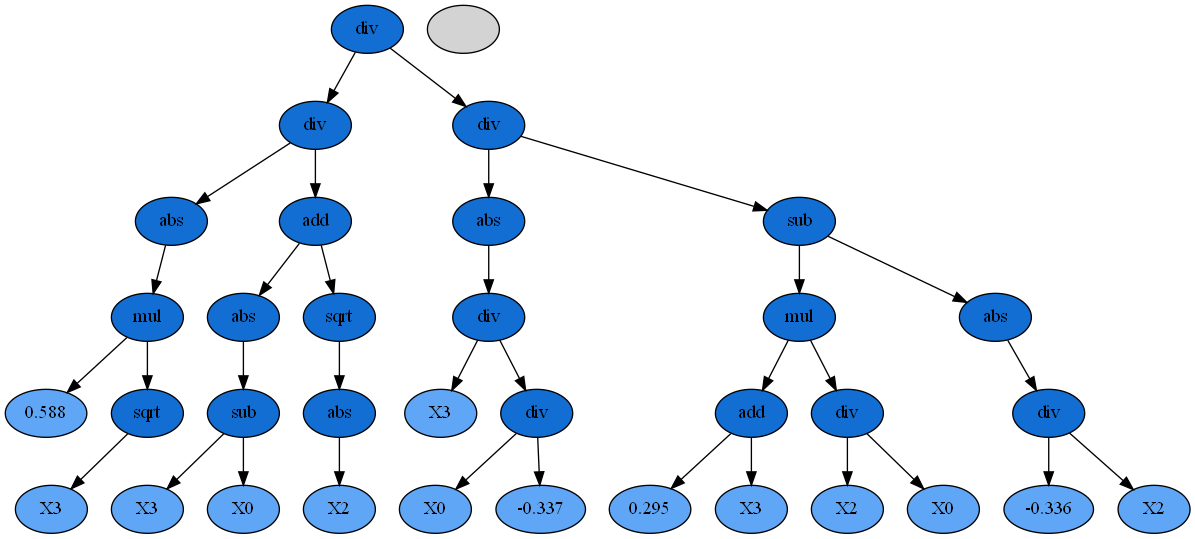

In [6]:
from gplearn.functions import _function_map
from gplearn._program import _Program

reg = SymbolicRegressor()

function_set = [_function_map[i] for i in ['add', 'sub', 'mul', 'div', 'abs', 'sqrt']]
# function_set.extend([rbeta, ralpha, rargmax, rargmin, rcorr, rdecay, 
#                      rmean, rstd, rzscore])
arities = {}
for function in function_set:
    arity = function.arity
    arities[arity] = arities.get(arity, [])
    arities[arity].append(function)
X, y, sample_weight, trans_args, _, _ = \
    reg._validate_data(x_is, y_is, None, add_is, fit=True)
n_features = X.shape[1]
program = _Program(
    function_set=function_set,
    arities=arities,
    init_depth=(4, 7),
    init_method='grow',
    n_features=n_features,
    const_range=reg.const_range,
    metric=metric,
    p_point_replace=0.1,
    p_grow_terminal=0.1,  # Chance of choosing terminal over func on any node.
    parsimony_coefficient=1e-2,
    random_state=np.random.RandomState(np.random.randint(114514)),
    transformer=transform,
    feature_names=reg.feature_names,
    program=None,
)

print(program)
graph = program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

In [7]:
program.raw_fitness_, pnl = program.raw_fitness(X, y, sample_weight, 
                                                trans_args, return_pnl=True)
program.raw_fitness_

-0.0018425773182052056

In [8]:
pop_size, tour_size = 500, 10
prob = np.power(np.arange(1, pop_size+1) / pop_size, tour_size)
prob[1:] = prob[1:] - prob[:-1]
prob[::-1].round(3)[:100]

array([0.02 , 0.019, 0.019, 0.019, 0.018, 0.018, 0.018, 0.017, 0.017,
       0.017, 0.017, 0.016, 0.016, 0.016, 0.015, 0.015, 0.015, 0.015,
       0.014, 0.014, 0.014, 0.013, 0.013, 0.013, 0.013, 0.012, 0.012,
       0.012, 0.012, 0.012, 0.011, 0.011, 0.011, 0.011, 0.011, 0.01 ,
       0.01 , 0.01 , 0.01 , 0.01 , 0.009, 0.009, 0.009, 0.009, 0.009,
       0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.007, 0.007,
       0.007, 0.007, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006,
       0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004,
       0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003,
       0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003,
       0.003])

In [9]:
# backup = os.environ.get('PYTHONWARNINGS', None)
# os.environ['PYTHONWARNINGS'] = 'ignore'

kwargs = {
    'generations': 4,
    'metric': metric,
    'transformer': transform,
    'stopping_criteria': 100.,
    'population_size': 100,
    'init_depth': (2, 4),
    'tournament_size': 10,
    'parsimony_coefficient': 1e-4,
    'p_grow_terminal': 0.1,
    'p_crossover': 0.85,
    'p_subtree_mutation': 0.05,
    'p_hoist_mutation': 0.05,
    'p_point_mutation': 0.05,
    'p_point_replace': 0.1,
    'is_split': 0.8,
    'elitism': 5,
    'variety': 'corr',
    'verbose': 1,
    'n_jobs': 12,
    # 'function_set': ['add', 'sub', 'mul', 'div', 'abs', 'neg', 'inv', rbeta, 
    #                  ralpha, rargmax, rargmin, rcorr, rdecay, rmax, 
    #                  rmean, rmin, rstd, rzscore],
    'function_set': ['add', 'sub', 'mul', 'div', 'abs', 'neg', 'inv'],
    'callbacks': [DynamicParamCallback(min_fitness=0.005, min_variety=0.4, 
                                       max_avg_length=30), 
                  SaveCallback()],
    # 'const_range': None,
}

reg = SymbolicRegressor(**kwargs)
reg.fit(x_is, y_is, sample_weight=None, trans_args=add_is)

# if backup:
#     os.environ['PYTHONWARNINGS'] = backup
# else:
#     del os.environ['PYTHONWARNINGS']

    |    Population Average    |     Best Individual      |
---- -------------------------- -------------------------- ----------
 Gen   Length  Variety  Fitness   Length  Fitness OS Fitness  Time Left
   0     9.52     0.54  -0.0485       10   0.0033  -0.0022      2.56m
   1     9.67     0.56  -0.0059        6   0.0045   0.0016      1.54m
   2     9.95     0.57  -0.0160        6   0.0045   0.0016     44.10s
   3    10.50     0.58  -0.0059        6   0.0045   0.0016      0.00s


SymbolicRegressor(_metric=<gplearn.fitness._Fitness object at 0x00000164B15C58A0>,
                  _transformer=<gplearn.functions._Function object at 0x00000164B1453C10>,
                  arities={1: [<gplearn.functions._Function object at 0x00000164B15C7760>,
                               <gplearn.functions._Function object at 0x00000164B15C76A0>,
                               <gplearn.functions._Function object at 0x00000164B15C7700>],
                           2: [<gplearn.functions...
                  metric=<gplearn.fitness._Fitness object at 0x00000164B15C58A0>,
                  n_jobs=12, p_crossover=0.44, p_hoist_mutation=0.05,
                  p_point_mutation=0.1, p_point_replace=0.5,
                  p_subtree_mutation=0.4, parsimony_coefficient=0.0001,
                  population_size=100, return_pnl=True, stopping_criteria=100.0,
                  tournament_size=2,
                  transformer=<gplearn.functions._Function object at 0x00000164B1453C10>,
                  verbose=1)

In [10]:
population = reg._programs[-1]
if not hasattr(population[0], '_pnl'):
    for program in population:
        fitness, pnl = program.raw_fitness(X, y, sample_weight, 
                                           trans_args, return_pnl=True)
        program._pnl = pnl
population = list(sorted(population, key=lambda x: x.raw_fitness_, reverse=True))

In [11]:
pnl = np.stack([i._pnl for i in population], axis=1)
corr = np.corrcoef(pnl, rowvar=False)

In [15]:
port_idx = [0]
min_ic, max_abs_corr = 0., 0.8
for i, program in enumerate(population):
    if program.raw_fitness_ < min_ic:
        break
    if np.abs(corr[i, port_idx]).max() < max_abs_corr:
        port_idx.append(i)
port_idx

[0, 1, 3, 5, 7, 9, 10, 11, 17, 18, 20]

In [16]:
ret = np.nanmean(pnl[:, port_idx], axis=0)
cov = np.cov(pnl[:, port_idx], rowvar=False)

In [25]:
# Optimize target: w.T @ ret / sqrt(w.T @ cov @ w)
# s.t. sum(w) = 1, w >= 0
from scipy.optimize import minimize, Bounds, LinearConstraint

def target(w, ret, cov):
    return -w @ ret / np.sqrt(w @ cov @ w)

bounds = Bounds(0., 1.)
linear_constraint = LinearConstraint(np.ones_like(ret), 1., 1.)

w0 = np.ones_like(ret) / len(ret)
res = minimize(target, w0, args=(ret, cov), constraints=linear_constraint, 
               bounds=bounds, method='trust-constr')
res

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -0.07759610709134485
                 x: [ 1.818e-04  5.343e-04  9.961e-01  3.365e-04  1.517e-04
                      2.380e-04  1.185e-04  1.604e-04  1.911e-03  1.686e-04
                      7.022e-05]
               nit: 25
              nfev: 228
              njev: 19
              nhev: 0
          cg_niter: 30
      cg_stop_cond: 4
              grad: [ 3.687e-02  1.403e-02 -7.034e-05  1.688e-02  4.669e-02
                      2.801e-02  5.408e-02  4.315e-02  5.271e-03  4.106e-02
                      8.701e-02]
   lagrangian_grad: [ 1.230e-12  1.205e-10 -8.490e-10 -4.261e-10  6.644e-11
                     -2.843e-11 -2.173e-11  4.176e-11  1.082e-09  4.185e-11
                     -2.843e-11]
            constr: [array([ 1.000e+00]), array([ 1.818e-04,  5.343e-04,  9.961e-01,  3.365e-04,
                            1.517e-04,  2.380e-04,  1.185e-0

In [19]:
def sharpe_pnl(arr):
    return np.nanmean(arr) / np.nanstd(arr) * np.sqrt(250)

benchmark = pnl[:, 0]
sharpe_pnl(benchmark)

0.5141166507255871

In [20]:
weight = res.x
pnl_port = np.nansum(pnl[:, port_idx] * weight[None, :], axis=1)
sharpe_pnl(pnl_port)

1.2281663761510424

In [104]:
corr

array([[1.        , 0.99949522, 0.99949504, 0.99949504, 0.99949504,
        0.99949485, 0.99079086, 0.99211283, 0.99196243, 0.99053711],
       [0.99949522, 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99166461, 0.99198163, 0.9915947 , 0.99164892],
       [0.99949504, 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99166495, 0.99198167, 0.99159467, 0.99164932],
       [0.99949504, 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99166495, 0.99198167, 0.99159467, 0.99164932],
       [0.99949504, 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99166495, 0.99198167, 0.99159467, 0.99164932],
       [0.99949485, 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99166518, 0.99198113, 0.99159414, 0.99164953],
       [0.99079086, 0.99166461, 0.99166495, 0.99166495, 0.99166495,
        0.99166518, 1.        , 0.98853241, 0.98845495, 0.99968688],
       [0.99211283, 0.99198163, 0.9919816

In [97]:
p = np.nanmean(pnls, axis=1)
sharpe_pnl(p)

2.0042725650058606

In [81]:
%timeit program.execute(X)
%timeit program.raw_fitness(X, y, sample_weight, trans_args, return_pnl=True)

104 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.53 s ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
negative = False
pred_is = reg.predict(x_is, add_is, negative=negative, transform=False)
pred_os = reg.predict(x_os, add_os, negative=negative, transform=False)
stats_is, pnl_is = all_stats(y_is, pred_is, 1.)
stats_os, pnl_os = all_stats(y_os, pred_os, pnl_is.iat[-1])
stats = pd.concat([stats_is, stats_os], axis=0)
stats[stats['days'] > 10]

,days,ret,sharpe,ret_long,sharpe_long,long_size,short_size,min_coverage,coverage,maxwt,avg_maxwt,max_tvr,avg_tvr,max_dd
2020,243.0,0.002236,2.257286,0.000252,2.269459,0.916580,-0.916710,0.000000,0.848185,0.009251,0.006050,1.955277,0.227669,-0.151252
2021,243.0,0.002065,2.393498,0.000116,0.965509,0.999563,-1.000295,0.912517,0.923020,0.006890,0.005816,0.436897,0.232419,-0.129500
ALL,486.0,0.002150,2.317543,0.000184,1.591767,0.958071,-0.958502,0.000000,0.885602,0.009251,0.005933,1.955277,0.230044,-0.151252
2022,58.0,0.000433,0.637983,0.000008,0.112609,0.672131,-0.671543,0.000000,0.620354,0.006108,0.003987,1.945369,0.176049,-0.050077
ALL,59.0,0.000426,0.632638,0.000008,0.111667,0.660738,-0.660161,0.000000,0.609839,0.006108,0.003919,1.945369,0.173065,-0.050077


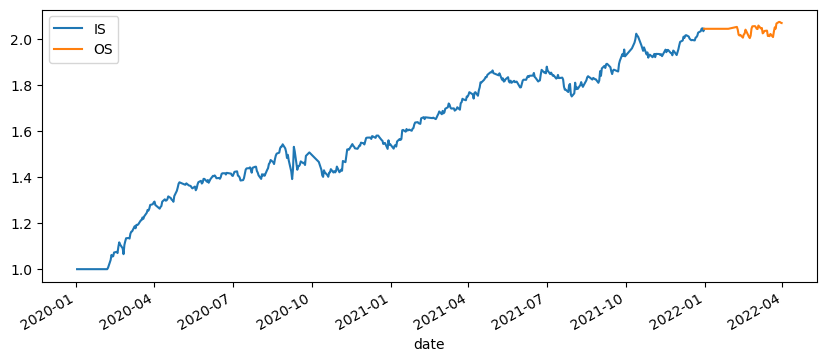

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
pnl_is.plot(ax=ax)
pnl_os.plot(ax=ax)
plt.legend(['IS', 'OS'])
plt.show()

In [173]:
# with open('./last_tree.pkl', 'wb') as f:
#     pickle.dump(reg, f)
# with open('./last_tree.pkl', 'rb') as f:
#     reg = pickle.load(f)

mul(rstd(10, mul(mul(X2, X0), X1)), rdecay(20, mul(mul(mul(X2, X1), X1), X1)))


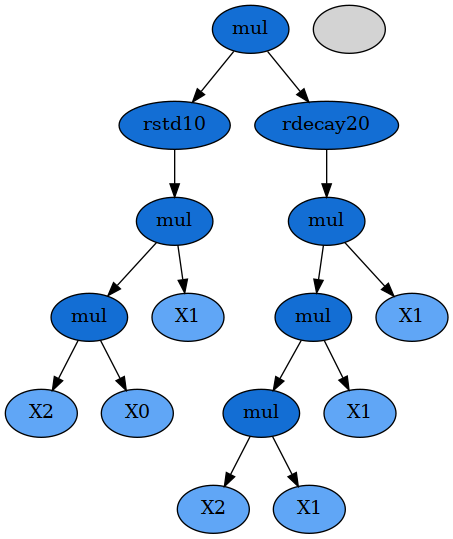

In [32]:
print(reg._program)
graph = reg._program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

In [33]:
pred_full = reg.predict(x_full, add_full, transform=True)
stats_full, pnl_full = all_stats(ret, pred_full)
stats_full

,days,ret,sharpe,ret_long,sharpe_long,long_size,short_size,min_coverage,coverage,maxwt,avg_maxwt,max_tvr,avg_tvr,max_dd
2009,244.0,0.001677,3.647523,0.000324,3.222340,0.912751,-0.926602,0.000000,0.812383,0.015865,0.011104,1.881087,0.316108,-0.053995
2010,242.0,0.000559,0.905882,0.000111,0.934516,0.997300,-1.007671,0.845774,0.858473,0.016089,0.011357,0.903722,0.317330,-0.085333
2011,244.0,0.000976,1.812171,0.000136,1.941005,0.995386,-1.009108,0.861466,0.884062,0.013005,0.010396,1.337188,0.284910,-0.073733
2012,243.0,0.001863,3.842183,0.000151,2.231282,0.996914,-1.004789,0.896120,0.916154,0.011504,0.009443,0.821644,0.275544,-0.055495
2013,238.0,0.000967,1.309089,0.000054,0.498868,0.991797,-1.021701,0.945543,0.954169,0.010381,0.008578,1.057935,0.274881,-0.150779
2014,245.0,0.000795,1.283184,-0.000106,-1.253637,0.982704,-1.039984,0.926425,0.939022,0.010724,0.009455,0.627091,0.260601,-0.124621
2015,244.0,0.001819,2.145101,-0.000092,-0.476993,0.930681,-1.089430,0.842954,0.902637,0.009029,0.006743,1.552812,0.320968,-0.108357
2016,244.0,0.002015,3.674526,-0.000159,-1.768266,0.975177,-1.055677,0.914826,0.923521,0.010480,0.007827,1.599581,0.271845,-0.071912
2017,244.0,0.002271,3.485566,-0.000262,-3.153741,0.989697,-1.032459,0.902853,0.915912,0.010183,0.008987,0.641095,0.246384,-0.088903
2018,243.0,0.002135,3.763334,0.000099,1.286721,0.992994,-1.019290,0.920617,0.945388,0.007701,0.006675,1.012136,0.274355,-0.064431


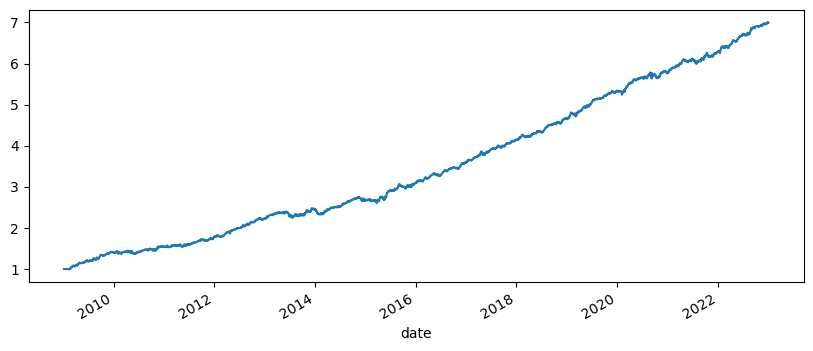

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
pnl_full.plot(ax=ax)
plt.show()

In [36]:
idx = pred_full.index.to_series().reset_index(drop=True).dt.strftime(r'%Y%m%d')
pred_full.reset_index(drop=True, inplace=True)
pred_full['date'] = idx
pred_full = pred_full.drop_duplicates(subset=['date']).reset_index(drop=True)
pred_full.to_csv('/work/thchu/alpha_dump/gptest_ts.csv', sep='|', index=None)
pred_full.sample(10)

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI,date
3004,0.000318,0.000322,0.000311,NaN,0.000322,NaN,0.000322,0.000297,0.000262,0.000260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210517
611,0.000722,0.000707,0.000687,0.000708,0.000421,NaN,NaN,-0.003441,NaN,-0.007958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20110711
2115,0.000396,0.000352,0.000370,-0.000238,0.000364,0.000390,0.000407,0.000372,0.000405,-0.003469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170913
2296,0.000395,0.000390,0.000390,0.000387,0.000393,0.000387,0.000370,0.000395,0.000077,0.000391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20180614
2762,0.000387,0.000387,-0.000220,0.000387,0.000351,0.000373,0.000388,-0.001090,NaN,0.000379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200518
54,0.000938,0.000894,NaN,0.000885,-0.003481,NaN,NaN,-0.000583,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20090327
837,0.000668,0.000579,0.000535,0.000568,0.000270,0.000118,NaN,0.000628,NaN,-0.000411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20120615
2087,0.000368,0.000394,0.000388,0.000421,0.000428,0.000281,0.000431,-0.000197,0.000431,0.000402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20170804
909,0.000615,0.000602,0.000537,0.000509,0.000616,0.000504,NaN,0.000595,NaN,0.000395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20120926
549,0.000711,0.000668,NaN,0.000676,0.000657,NaN,NaN,-0.000503,NaN,0.000383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20110412


In [171]:
def _div(x1, x2):
    d = x1 / x2
    # # Safe method 1
    # d = d.where(x2.abs() > 1e-6, 1.)
    # # Safe method 2
    # d = d.where(x2.abs() > 1e-6, 0.)
    # Safe method 3
    d = d.where(d.abs() < 100, 0.)
    return d

temp = open_ * open_ * open_ * open_ \
    * ((_div(high-low, low-0.636) + open_) - high)

# temp = open_ * open_ * (open_ - high)

# temp -= temp.mean(axis=1).to_numpy()[..., None]
# pos = temp.where(temp > 0., 0.).sum(axis=1)
# neg = -temp.where(temp < 0., 0.).sum(axis=1)
# temp = temp.where(temp < 0, temp / pos.to_numpy()[..., None])
# temp = temp.where(temp > 0, temp / neg.to_numpy()[..., None])
# minimum = temp.quantile(0.01, axis=1).to_numpy()
# maximum = temp.quantile(0.99, axis=1).to_numpy()
# temp = temp.clip(minimum, maximum, axis=0)
# temp -= temp.mean(axis=1).to_numpy()[..., None]
# pos = temp.where(temp > 0., 0.).sum(axis=1)
# neg = -temp.where(temp < 0., 0.).sum(axis=1)
# temp = temp.where(temp < 0, temp / pos.to_numpy()[..., None])
# temp = temp.where(temp > 0, temp / neg.to_numpy()[..., None])

# idx = temp.index.to_series().reset_index(drop=True).dt.strftime(r'%Y%m%d')
# temp.reset_index(drop=True, inplace=True)
# temp['date'] = idx
# temp = temp.drop_duplicates(subset=['date']).reset_index(drop=True)
# temp.to_csv('/work/thchu/alpha_dump/gptest1.csv', sep='|', index=None)
temp

ticker,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,873527.BJ,000016.SH,000300.SH,000852.SH,000905.SH,000985.CSI,H00016.CSI,H00300.CSI,H00852.CSI,H00905.CSI
date,,,,,,,,,,,,,,,,,,,,,
2009-01-05,3.128802e-15,2.471462e-11,NaN,4.225163e-15,-5.130229e-17,NaN,NaN,7.361529e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,2.000975e-11,5.729874e-15,NaN,1.099730e-11,-9.128957e-11,NaN,NaN,2.965004e-16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,2.907080e-11,5.924057e-12,NaN,5.531156e-10,3.314360e-12,NaN,NaN,5.988390e-11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-08,-4.343906e-10,1.652415e-15,NaN,1.027864e-10,9.130288e-13,NaN,NaN,-9.951812e-12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-09,3.561069e-11,1.960171e-11,NaN,1.330863e-15,7.141804e-14,NaN,NaN,2.474091e-11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3.370713e-12,1.341767e-12,NaN,NaN,-6.456556e-09,-5.286571e-12,1.861877e-11,9.124766e-12,1.156194e-10,-2.484015e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,1.188275e-16,1.902945e-12,NaN,NaN,-3.736604e-07,1.145973e-11,4.958688e-15,4.731321e-12,-6.143569e-12,4.991140e-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,8.570933e-12,3.572355e-14,NaN,NaN,-1.362217e-09,3.955644e-12,9.181214e-13,3.190857e-10,6.817633e-13,-4.016158e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
import itertools
from abc import ABCMeta, abstractmethod
from collections import Iterable
from time import time
from warnings import warn

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import rankdata
from sklearn.base import BaseEstimator
from sklearn.base import RegressorMixin, TransformerMixin, ClassifierMixin
from sklearn.exceptions import NotFittedError
from sklearn.utils import compute_sample_weight
from sklearn.utils.validation import check_array, _check_sample_weight
from sklearn.utils.multiclass import check_classification_targets

from gplearn._program import _Program
from gplearn.fitness import _fitness_map, _Fitness
from gplearn.functions import _function_map, _Function, sig1 as sigmoid
from gplearn.utils import _partition_estimators
from gplearn.utils import check_random_state

def _parallel_evolve(n_programs, parents, X, y, sample_weight, 
                     trans_args, seeds, params):
    timer = time()
    if isinstance(parents, bytes):
        parents = cloudpickle.loads(parents)
    n_samples, n_features = X.shape[:2]
    # Unpack parameters
    tournament_size = params['tournament_size']
    function_set = params['function_set']
    arities = params['arities']
    init_depth = params['init_depth']
    init_method = params['init_method']
    p_grow_terminal = params['p_grow_terminal']
    const_range = params['const_range']
    metric = params['_metric']
    transformer = params['_transformer']
    parsimony_coefficient = params['parsimony_coefficient']
    method_probs = params['method_probs']
    p_point_replace = params['p_point_replace']
    is_split = params['is_split']
    feature_names = params['feature_names']
    return_pnl = params['return_pnl']

    is_split = int(is_split * n_samples)

    def _tournament():
        """Find the fittest individual from a sub-population."""
        contenders = random_state.randint(0, len(parents), tournament_size)
        fitness = [parents[p].fitness_ for p in contenders]
        if metric.greater_is_better:
            parent_index = contenders[np.argmax(fitness)]
        else:
            parent_index = contenders[np.argmin(fitness)]
        return parents[parent_index], parent_index
    
    current = time()
    print(f'Init takes {current - timer:5f}s')
    timer = current
    # Build programs
    programs = []
    times = []
    
    for i in range(n_programs):

        random_state = check_random_state(seeds[i])

        if parents is None:
            program = None
            genome = None
        else:
            method = random_state.uniform()
            parent, parent_index = _tournament()

            if method < method_probs[0]:
                # crossover
                donor, donor_index = _tournament()
                program, removed, remains = parent.crossover(donor.program,
                                                             random_state)
                genome = {'method': 'Crossover',
                          'parent_idx': parent_index,
                          'parent_nodes': removed,
                          'donor_idx': donor_index,
                          'donor_nodes': remains}
            elif method < method_probs[1]:
                # subtree_mutation
                program, removed, _ = parent.subtree_mutation(random_state)
                genome = {'method': 'Subtree Mutation',
                          'parent_idx': parent_index,
                          'parent_nodes': removed}
            elif method < method_probs[2]:
                # hoist_mutation
                program, removed = parent.hoist_mutation(random_state)
                genome = {'method': 'Hoist Mutation',
                          'parent_idx': parent_index,
                          'parent_nodes': removed}
            elif method < method_probs[3]:
                # point_mutation
                program, mutated = parent.point_mutation(random_state)
                genome = {'method': 'Point Mutation',
                          'parent_idx': parent_index,
                          'parent_nodes': mutated}
            else:
                # reproduction
                program = parent.reproduce()
                genome = {'method': 'Reproduction',
                          'parent_idx': parent_index,
                          'parent_nodes': []}

        program = _Program(function_set=function_set,
                           arities=arities,
                           init_depth=init_depth,
                           init_method=init_method,
                           n_features=n_features,
                           metric=metric,
                           transformer=transformer,
                           const_range=const_range,
                           p_grow_terminal=p_grow_terminal,
                           p_point_replace=p_point_replace,
                           parsimony_coefficient=parsimony_coefficient,
                           feature_names=feature_names,
                           random_state=random_state,
                           program=program)

        program.parents = genome
        current = time()
        times.append([current-timer])
        timer = current

        # Draw samples, using sample weights, and then fit
        if sample_weight is None:
            # curr_sample_weight = np.ones((n_samples,))
            curr_sample_weight = np.ones_like(y, dtype=float)
        else:
            curr_sample_weight = sample_weight.copy()
        # # Broadcast weight matrix to be compatible with y.
        # if y.shape != curr_sample_weight.shape:
        #     err_msg = f'Cannot cast sample weight to the shape of y:'\
        #         f'{curr_sample_weight.shape} -> {y.shape}'
        #     diff = len(y.shape) - len(curr_sample_weight.shape)
        #     if diff > 0:
        #         # Assume later dims are missing.
        #         curr_sample_weight = np.expand_dims(
        #             curr_sample_weight,
        #             axis=np.arange(diff)+len(y.shape),
        #         )
        #         try:
        #             curr_sample_weight = np.broadcast_to(curr_sample_weight, 
        #                                                 y.shape).copy()
        #         except Exception:
        #             raise RuntimeError(err_msg)
        #     else:
        #         raise RuntimeError(err_msg)
        os_sample_weight = curr_sample_weight.copy()

        indices, not_indices = program.get_all_indices(n_samples, is_split)

        curr_sample_weight[not_indices] = 0
        os_sample_weight[indices] = 0

        res = program.raw_fitness(X, y, curr_sample_weight, 
                                  trans_args, return_pnl=return_pnl)
        if return_pnl:
            program.raw_fitness_ = res[0]
            program._pnl = res[1]
        else:
            program.raw_fitness_ = res
        if is_split < n_samples:
            # Calculate OS fitness
            program.os_fitness_ = program.raw_fitness(X, y, os_sample_weight,
                                                       trans_args)
        programs.append(program)
        current = time()
        times[-1].append(current-timer)
        timer = current

    times = np.array(times)
    mean, std = times.mean(axis=0), times.std(axis=0)
    print(f'Avg reproduction: {mean[0]:.3f} +- {std[0]:.3f} s, '
          f'Avg fitness: {mean[1]:.3f} +- {std[1]:.3f} s')
    return programs, times

In [ ]:
from gplearn.genetic import _parallel_evolve
from gplearn.utils import _partition_estimators
from joblib import Parallel, delayed
import itertools
import os

backup = os.environ.get('PYTHONWARNINGS', None)
os.environ['PYTHONWARNINGS'] = 'ignore'

n_jobs = 32
pop_size = 200
seed = 42
parents = None

params = reg.get_params()
random_state = np.random.RandomState(seed)
n_jobs, n_programs, starts = _partition_estimators(
    pop_size, n_jobs)
seeds = random_state.randint(114514, size=pop_size)

# population = _parallel_evolve(pop_size, parents, X, y, sample_weight, 
#                                      trans_args, seeds, params)

population = Parallel(n_jobs=n_jobs,
                        verbose=int(reg.verbose > 1))(
    delayed(_parallel_evolve)(n_programs[i],
                                parents,
                                X,
                                y,
                                sample_weight,
                                trans_args,
                                seeds[starts[i]:starts[i + 1]],
                                params)
    for i in range(n_jobs))
                        
if backup:
    os.environ['PYTHONWARNINGS'] = backup
else:
    del os.environ['PYTHONWARNINGS']

# Reduce, maintaining order across different n_jobs
population = list(itertools.chain.from_iterable(population))

In [20]:
population = list(sorted(population, key=lambda x: x.raw_fitness_))
[i.raw_fitness_ for i in population]

[-1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -0.020598890471207547,
 -0.017218185005857607,
 -0.017154756890528942,
 -0.01702123738303346,
 -0.015236193181741242,
 -0.013720950220384408,
 -0.01272167916449428,
 -0.011222593084834254,
 -0.010505361514662706,
 -0.01029006797921795,
 -0.010190302270311969,
 -0.009861634978372596,
 -0.00975230699350768,
 -0.009665774681953686,
 -0.009329182094680494,
 -0.009210544340728944,
 -0.009157417906216821,
 -0.008731705411967688,
 -0.008357738884255297,
 -0.008311930970409965,
 -0.008259971733142343,
 -0.00771269061607054,
 -0.007637091401156099,
 -0.007570013913643294,
 -0.007456347882040233,
 -0.007299349374239534,
 -0.007133515045393283,
 -0.007092173060699281,
 -0.006691461023096295,
 -0.00647784004829733,
 -0.0064053630860941195,
 -0.0063850972701448684,
 -0.006333883737711361,
 -0.00610

div(rzscore((60, 60), div(abs(X1), abs(X1))), X2)
0.0


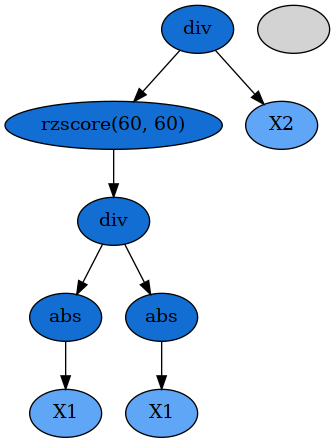

In [23]:
program = population[2]
pred = program.execute(X)
print(program)
print(np.isfinite(pred).mean())
graph = program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

In [58]:
pred

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 2.,  2.,  1., ...,  5.,  1.,  1.],
       [ 1.,  1.,  5., ...,  5.,  1.,  5.],
       [ 1.,  1.,  4., ...,  4.,  1.,  4.]])

In [57]:
program.transformer(None, pred, trans_args)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [103]:
times = times[:, 1].round(3)
idx = np.argmax(times)
# times = np.stack([times, np.arange(len(times))], axis=1)
print(idx, times[idx])
times

4 1.601


array([0.458, 0.166, 0.934, 0.641, 1.601, 0.403, 0.947, 0.625, 0.542,
       0.407])

rcorr(5, ralpha(5, inv(rmax(5, X3)), ralpha(60, rstd(20, X2), rskew(10, X0))), rzscore((5, 5), sub(sub(X2, X1), rkurt(10, X2))))


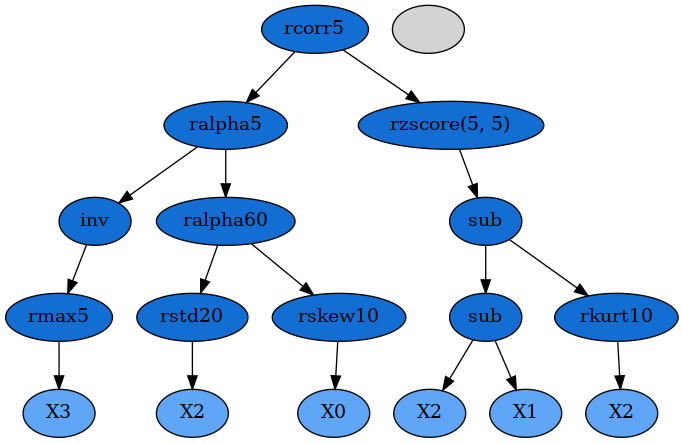

In [104]:
program = population[idx]
print(program)
graph = program.export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

In [92]:
x1 = rargmin(20, X[:, 0])
x2 = rbeta(20, np.full_like(X[:, 0], 0.944), X[:, 0])
x2 = ralpha(5, x1, x2)
x1 = rmedian(60, X[:, 1])

In [83]:
vret = dm['RETURN_V2V'].data_array.to_pandas()
vret = vret.where(pool, np.nan)
vret_slice = vret.loc['2020-09-10', :]

In [21]:
wt_slice = temp.loc['2020-09-10', :]
ret_slice = ret.loc['2020-09-10', :]
prev_wt_slice = temp.loc['2020-09-09', :]
prev_ret_slice = ret.loc['2020-09-09', :]

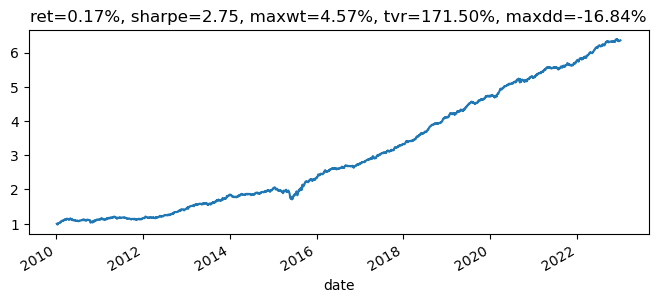

In [93]:
p.plot(figsize=(8, 3))
msg = f'ret={s[-1]["ret"]:.2%}, sharpe={s[-1]["sharpe"]:.2f}, '\
    f'maxwt={s[-1]["max_wt"]:.2%}, tvr={s[-1]["avg_tvr"]:.2%}, '\
    f'maxdd={s[-1]["max_dd"]:.2%}'
plt.title(msg)
plt.show()

In [134]:
len(temp['date'].unique())

1580

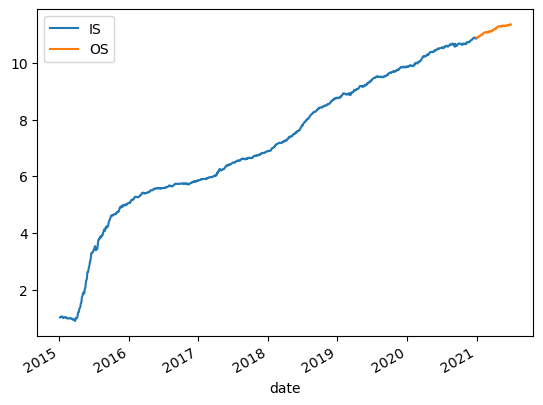

In [114]:
port = y_is[0] * pd.DataFrame(pred_is[0], index=is_label, columns=ret.columns)
port_os = y_os[0] * pd.DataFrame(pred_os[0], index=os_label, 
                                 columns=ret.columns)
port, port_os = port.sum(axis=1).cumsum(), port_os.sum(axis=1).cumsum()
port += 1.
port_os += port.iat[-1]
port.plot()
port_os.plot()
plt.legend(['IS', 'OS'])
plt.show()

In [57]:
x_full = np.stack([i.to_numpy() 
                for i in [open_, high, low, close]], axis=0)[None, ...]
y_full = ret.to_numpy()[None, ...]
pred_full = transform_weight(reg.predict(x_full))
stats_full = pd.Series(all_stats(y_full, pred_full)).to_frame('FULL')
stats_full

,FULL
days,3560.000000
ret,0.008532
sharpe,7.746726
min_long,0.000000
min_short,0.000000
avg_long,0.999140
avg_short,-0.999121
min_coverage,0.000000
avg_coverage,0.568995
max_weight,0.056427


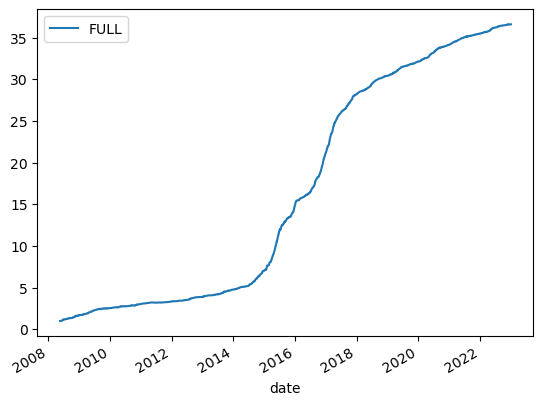

In [58]:
port = y_full[0] * pd.DataFrame(pred_full[0], index=ret.index, 
                                columns=ret.columns)
port = port.sum(axis=1).cumsum()
port += 1.
port.plot()
plt.legend(['FULL'])
plt.show()

In [65]:
reg.fit(x_is[:, [3], ...], y_is)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    47.31         -3.52564       63          3.11505              N/A     38.56s
   1     9.19        -0.905794       11          2.98389              N/A     17.87s
   2     7.85        -0.245319       15          2.98389              N/A     12.81s
   3    12.15          0.32504       23          3.47644              N/A      7.35s
   4    11.21         0.760119       21          4.46477              N/A      0.00s


SymbolicRegressor(generations=5,
                  metric=<gplearn.fitness._Fitness object at 0x7f77e1d0c550>,
                  n_jobs=32, p_crossover=0.85, p_hoist_mutation=0.05,
                  parsimony_coefficient=0.1, population_size=600,
                  stopping_criteria=100.0,
                  transformer=<gplearn.functions._Function object at 0x7f77e1d10160>,
                  verbose=1)

In [66]:
pred_is = transform_weight(reg.predict(x_is[:, [3], ...]))
pred_os = transform_weight(reg.predict(x_os[:, [3], ...]))
stats_is = pd.Series(all_stats(y_is, pred_is)).to_frame('IS')
stats_os = pd.Series(all_stats(y_os, pred_os)).to_frame('OS')
pd.concat([stats_is, stats_os], axis=1)

,IS,OS
days,243.000000,59.000000
ret,0.003876,0.001892
sharpe,4.464767,2.621978
min_long,0.999109,0.999577
min_short,-0.996655,-0.999858
avg_long,0.999987,0.999979
avg_short,-0.999922,-0.999990
min_coverage,0.723813,0.796079
avg_coverage,0.753752,0.805275
max_weight,0.025696,0.021991


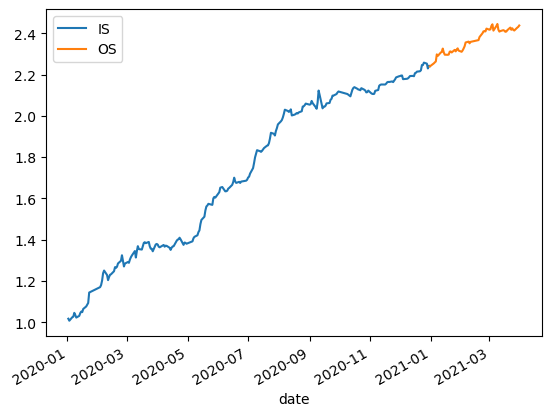

In [67]:
port = y_is[0] * pd.DataFrame(pred_is[0], index=is_label, columns=ret.columns)
port_os = y_os[0] * pd.DataFrame(pred_os[0], index=os_label, 
                                 columns=ret.columns)
port, port_os = port.sum(axis=1).cumsum(), port_os.sum(axis=1).cumsum()
port += 1.
port_os += port.iat[-1]
port.plot()
port_os.plot()
plt.legend(['IS', 'OS'])
plt.show()

In [143]:
idx = port_sum.argmax()
print(port.iloc[idx].name)
daily = pd.concat([port.iloc[idx], wt.iloc[idx]], axis=1)
daily.columns = ['wtdret', 'wt']
daily['ret'] = daily['wtdret'] / daily['wt']
daily = daily.dropna().sort_values('wtdret')
daily.describe()

2020-03-06 00:00:00


,wtdret,wt,ret
count,3.802000e+03,3.802000e+03,3802.000000
mean,2.344626e-05,-7.300257e-21,-0.032445
std,2.029948e-04,2.437817e-03,0.036525
min,-2.252452e-03,-9.628102e-03,-0.128996
25%,-2.183870e-06,-2.555085e-04,-0.052257
50%,3.771315e-07,-9.145357e-06,-0.037028
75%,9.488383e-06,7.468453e-05,-0.019564
max,3.115116e-03,3.092865e-02,0.101961


In [127]:
port.iloc[idx].describe()

count    3.807000e+03
mean     2.341546e-05
std      2.028632e-04
min     -2.252452e-03
25%     -2.181351e-06
50%      3.686902e-07
75%      9.470051e-06
max      3.115116e-03
Name: 2020-03-06 00:00:00, dtype: float64

In [4]:
import pickle

with open('/home/thchu/notebook/dump.pkl', 'rb') as f:
    p = pickle.load(f)
    
print(type(p))

<class 'gplearn._program._Program'>


In [4]:
np.array([1., 1., 1.]).std()

0.0

In [48]:
class Operator:
    def __init__(self, next_op: Operator=None, params: tuple=()):
        self.next_op = next_op
        self.params = params
        
    def __eq__(self, other: Operator):
        return isinstance(other, Operator) \
            and self.__class__ is other.__class__ \
            and self.params == other.params \
            and self.next_op == other.next_op
    
    def __len__(self):
        if self.next_op is None:
            return 1
        return len(self.next_op) + 1
            
    @abstractmethod
    def __call__(self, *args):
        pass
    
    def __repr__(self):
        return f'{self.__class__.__name__}{self.params} <- {self.next_op}'
        

class NOP(Operator):
    def __call__(self, var):
        return var
    
    def __repr__(self):
        return 'input'


class Affine(Operator):
    def __call__(self, var):
        return self.next_op(var) * self.params[0] + self.params[1]
    
    
class TSMean(Operator):
    def __call__(self, var):
        op = calRollMean('cuda:5', self.params[0])
        op.update(self.next_op(var), slice_num=1)
        res = op.res.clone()
        del op
        return res
    
    
class TSMax(Operator):
    def __call__(self, var):
        op = calRollMax('cuda:5', self.params[0])
        op.update(self.next_op(var), slice_num=1)
        res = op.res.clone()
        del op
        return res

In [46]:
x = torch.randn(250, 4500, device='cuda:5')
x

tensor([[-2.3778, -0.3125,  0.1757,  ..., -0.4457,  0.5507,  0.6103],
        [ 2.3827, -0.6070,  0.1962,  ...,  1.0197,  0.2820,  0.8365],
        [ 2.0377,  0.5527, -1.1314,  ..., -0.3333, -1.1863,  0.5942],
        ...,
        [ 0.5500,  0.5570,  0.0533,  ..., -0.8959,  0.2662, -1.3402],
        [-1.4765, -1.1943,  0.4513,  ...,  0.7330,  0.8015, -0.0445],
        [ 0.6403,  0.3480, -0.0048,  ...,  0.4460, -1.3803, -0.5953]],
       device='cuda:5')

In [95]:
new_op = NOP()
new_op = TSMax(new_op, (20,))
new_op = TSMean(new_op, (5,))

op = NOP()
op = Affine(op, (1., 0.5))
op = TSMean(op, (10,))
op = TSMax(op, (10,))

print(len(new_op), new_op)
print(len(op), op)

3 TSMean(5,) <- TSMax(20,) <- input
4 TSMax(10,) <- TSMean(10,) <- Affine(1.0, 0.5) <- input


In [96]:
nbp, bp = 0, 1
a, b = new_op, op
for _ in range(nbp):
    a = a.next_op
for _ in range(bp):
    b = b.next_op
a.next_op, b.next_op = b.next_op, a.next_op

print(len(new_op), new_op)
print(len(op), op)

3 TSMean(5,) <- Affine(1.0, 0.5) <- input
4 TSMax(10,) <- TSMean(10,) <- TSMax(20,) <- input
